C:\Users\0141s\AppData\Local\Temp\ipykernel_11108\2906910289.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['市区町村コード'] = df['市区町村コード'].astype(str).str.zfill(5)
C:\Users\0141s\AppData\Local\Temp\ipykernel_11108\2906910289.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['KEY_CODE'] = df['市区町村コード'] + df['町丁字コード']
C:\Users\0141s\AppData\Local\Temp\ipykernel_11108\2906910289.py:69: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()

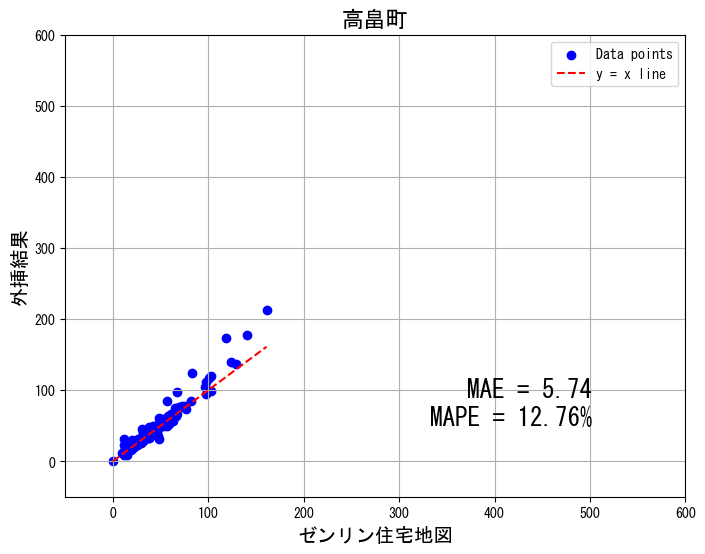

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely.wkt import loads
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# 日本語フォントの設定
font_path = 'C:/Windows/Fonts/msgothic.ttc'  # MS Gothicフォントのパス
font_manager.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'MS Gothic'


target_area = '06381'
target_municipalitiy = '高畠町'
# パスの設定
z_map_path = f'G:/マイドライブ/akiyamalab/オープン住宅地図/raw_data/住宅地図/004006201602/{target_area}/shapes/tatemono.shp'
bldg_path = f"G:/マイドライブ/akiyamalab/オープン住宅地図/dev_2025/extrapolation/predict/{target_area}/{target_area}.parquet"
city_polygon_path = "G:/マイドライブ/akiyamalab/オープン住宅地図/code_data/feture_engineering/census/6/A002005212020DDSWC06/r2ka06.shp"
how_to_build_path = "G:/マイドライブ/akiyamalab/オープン住宅地図/code_data/feture_engineering/census/6/第8表 _住宅の建て方別一般世帯数－町丁・字等2020.csv"
# KEY_CODEごとにgeometryを結合してmultipolygonにする


# データロード
z_map = gpd.read_file(z_map_path, encoding='cp932')
bldg = gpd.read_parquet(bldg_path)
city_polygon = gpd.read_file(city_polygon_path)
how_to_build = pd.read_csv(how_to_build_path, encoding='cp932', dtype={'市区町村コード': str, '町丁字コード': str})

city_polygon = city_polygon.dissolve(by='KEY_CODE')
city_polygon = city_polygon.reset_index()
city_polygon = city_polygon[city_polygon['CITY_NAME'] == target_municipalitiy]

def add_KEYCODE(df):
    if '男女' in df.columns:
        df = df[df['男女'] == '総数']
    #地域階層レベルが１は市区町村レベル，3は4が存在するときにものなので2，4を取得
    df = df[(df['地域階層レベル'] == 2) | (df['地域階層レベル'] == 4)]
    df.reset_index(drop=True, inplace=True)
    
    #csvに出力した際に落ちてしまう先頭の00を補完
    # 地域階層レベルに応じて町丁字コードをゼロ埋め
    df.loc[df['地域階層レベル'] == 2, '町丁字コード'] = df.loc[df['地域階層レベル'] == 2, '町丁字コード'].apply(lambda x: f"{int(x):04d}")
    df.loc[df['地域階層レベル'] == 4, '町丁字コード'] = df.loc[df['地域階層レベル'] == 4, '町丁字コード'].apply(lambda x: f"{int(x):06d}")
    
    #KEY＿CODEを文字列として結合
    df['市区町村コード'] = df['市区町村コード'].astype(str).str.zfill(5)
    df['KEY_CODE'] = df['市区町村コード'] + df['町丁字コード']
    
    return df

how_to_build = add_KEYCODE(how_to_build)
how_to_build = how_to_build[how_to_build['市区町村コード'] == f'{target_area}']
seacret_keycode = how_to_build[(how_to_build['一戸建'] == 'X') | (how_to_build['一戸建'] == '-')]['KEY_CODE'].to_list()

z_map.to_crs(crs=4326, inplace=True)
city_polygon.to_crs(crs=4326, inplace=True)

# KEY_CODEごとにgeometryを結合してmultipolygonにする
city_polygon = city_polygon.dissolve(by='KEY_CODE')
city_polygon = city_polygon.reset_index()

#住宅地図と小地域ポリゴンを結合
z_map['geometry'] = z_map['geometry'].centroid
z_map = gpd.sjoin(z_map, city_polygon, how='left', op='within')

#重心座標を出力
columns = ['KEY_CODE', 'tatemon_id', 'overlap', 'together', 'laynum', 'zmdatr_id', 'atrcode', 'bmap_id',
       'bmapname', 'chiban', 'housename', 'floor', 'bekkire_id', 'map_id',
       'hyosatu_id']
z_map = z_map[columns]


#住宅地図を住宅だけに絞る
z_map = z_map[z_map['atrcode'] == 1364]
# KEY_CODEをキーにグループ化し、行数をカウント
key_code_counts = z_map.groupby('KEY_CODE').size().reset_index(name='z_map')

#外挿の戸建て住宅数をカウント
# KEY_CODEをキーにprob_binaryの和を計算
key_code_sum = bldg.groupby('KEY_CODE')['presumed_detached'].sum().reset_index(name='extract')

# 'KEY_CODE'を文字列型に変換
key_code_sum['KEY_CODE'] = key_code_sum['KEY_CODE'].astype(str)
validate = pd.merge(key_code_counts, key_code_sum, how='outer', on='KEY_CODE')
validate['extract'] = validate['extract'].fillna(0)
validate['z_map'] = validate['z_map'].fillna(0)

validate = validate[~validate['KEY_CODE'].isin(seacret_keycode)]

# # 可視化用
# validate = gpd.GeoDataFrame(validate, geometry='geometry')



# 'extract' を説明変数（X）、'z_map' を目的変数（y）として回帰分析を行う
X = validate[['z_map']].values.reshape(-1, 1)  # 説明変数（2Dに変換）
y = validate['extract'].values  # 目的変数

# 線形回帰モデルを作成
model = LinearRegression()

# モデルを学習
model.fit(X, y)

# 予測を実行
y_pred = model.predict(X)

# ゼロ除算を回避して MAPE を計算する
nonzero_mask = y != 0
# 平均絶対誤差（MAE）を計算
mae = mean_absolute_error(y, y_pred)
mape = np.mean(np.abs((y[nonzero_mask] - y_pred[nonzero_mask]) / y[nonzero_mask])) * 100


# 回帰曲線の可視化
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color='blue', label='Data points')  # 元のデータ点
# plt.plot(X, y_pred, color='red', label='Regression line')  # 回帰直線

# y = x の線を描画
plt.plot([X.min(), X.max()], [X.min(), X.max()], color='red', linestyle='--', label='y = x line')

# MAEとMAPEを右下に表示
plt.text(0.85, 0.15, f'MAE = {mae:.2f}\nMAPE = {mape:.2f}%', 
         ha='right', va='bottom', transform=plt.gca().transAxes, fontsize=18)


# 縦軸と横軸のスケールを指定
plt.ylim(-50, 600)  # 縦軸の最小値と最大値を設定
plt.xlim(-50, 600)  # 横軸の最小値と最大値を縦軸に合わせて設定

# 決定係数を表示
# 決定係数を表示（右下に配置）
# plt.text(0.95, 0.05, f'R² = {r2:.3f}', ha='right', va='bottom', transform=plt.gca().transAxes, fontsize=12)

plt.title('高畠町', fontsize=16)

# グラフの設定
plt.xlabel('ゼンリン住宅地図', fontsize=14)
plt.ylabel('外挿結果', fontsize=14)
# plt.title('Linear Regression: extract vs z_map')
plt.legend()
plt.grid(True)

# グラフを表示
plt.show()

In [2]:
test = validate[validate['extract'] == 0]
test.sort_values(by='z_map', ascending=False)

,KEY_CODE,z_map,extract
64,06381012007,79.0,0
129,06381035019,60.0,0
21,06381002019,2.0,0
75,06381018014,2.0,0
96,06381024012,2.0,0
116,06381030015,2.0,0
63,06381012006,1.0,0
128,06381035018,1.0,0
133,None,0.0,0


In [6]:
target_area = '06381'
features_path = f"G:/マイドライブ/akiyamalab/オープン住宅地図/dev_2025/extrapolation/feature_engineering/{target_area}_features.parquet"
features = gpd.read_parquet(features_path)
features['一戸建'].mean()

48.746153846153845